In [1]:
# setting up the folder path 
folder_path = r'computing-usage-dataset/computing-usage-dataset'

# Function: `load_and_preprocess_data`

This function performs the following tasks:

- **Loads CSV files** from a specified folder.
- **Processes the data** by:
  - Handling timestamps for proper alignment.
  - Resampling the data to a consistent frequency.
  - **Interpolating missing values** to ensure data completeness.

By doing this, the function ensures that the data is cleaned and ready for further analysis, with a consistent structure and no missing timestamps.

---

### Example Usage:

Replace `'path/to/your/csv/folder'` with your actual folder path:

```python
folder_path = 'path/to/your/csv/folder'
datasets = load_and_preprocess_data(folder_path)


In [2]:
import pandas as pd
import os
from datetime import datetime

def load_and_preprocess_data(folder_path):
    """
    Loads and preprocesses CSV data files from a specified folder.

    Parameters:
    folder_path (str): The path to the folder containing CSV files.

    Returns:
    dict: A dictionary where the keys are file names and the values are DataFrames 
          with preprocessed data.
    """
    dfs = {}  # Dictionary to hold DataFrames for each file
    
    # Print statement to confirm the folder being processed
    print(f"Loading and processing data from folder: {folder_path}")

    # Loop through all files in the folder
    for file in os.listdir(folder_path):
        # Only process files with a .csv extension
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            print(f"Processing file: {file_path}")  # Indicate which file is being processed
            
            # Load CSV file into a DataFrame, parse the first column as datetime, and set it as the index
            df = pd.read_csv(file_path, parse_dates=[0], index_col=0)
            
            # Remove any duplicate timestamps from the DataFrame
            df = df[~df.index.duplicated(keep='first')]
            print(f"Removed duplicate timestamps for {file}")
            
            # Sort the DataFrame by the timestamp index to ensure chronological order
            df = df.sort_index()
            print(f"Sorted data by timestamp for {file}")
            
            # Resample the DataFrame to 5-minute intervals, using the mean of values within each interval
            df = df.resample('5min').mean()
            print(f"Resampled data to 5-minute intervals for {file}")
            
            # Interpolate missing values to fill gaps in the data
            df = df.interpolate()
            print(f"Interpolated missing values for {file}")
            
            # Store the processed DataFrame in the dictionary using the file name as the key
            dfs[file] = df
        else:
            print(f"Skipped non-CSV file: {file}")  # Inform if the file is not a CSV

    print("Data loading and preprocessing complete.")
    
    return dfs

#running the above function
datasets = load_and_preprocess_data(folder_path)

Loading and processing data from folder: computing-usage-dataset/computing-usage-dataset
Processing file: computing-usage-dataset/computing-usage-dataset/elb_request_count_8c0756.csv
Removed duplicate timestamps for elb_request_count_8c0756.csv
Sorted data by timestamp for elb_request_count_8c0756.csv
Resampled data to 5-minute intervals for elb_request_count_8c0756.csv
Interpolated missing values for elb_request_count_8c0756.csv
Processing file: computing-usage-dataset/computing-usage-dataset/ec2_cpu_utilization_fe7f93.csv
Removed duplicate timestamps for ec2_cpu_utilization_fe7f93.csv
Sorted data by timestamp for ec2_cpu_utilization_fe7f93.csv
Resampled data to 5-minute intervals for ec2_cpu_utilization_fe7f93.csv
Interpolated missing values for ec2_cpu_utilization_fe7f93.csv
Processing file: computing-usage-dataset/computing-usage-dataset/grok_asg_anomaly.csv
Removed duplicate timestamps for grok_asg_anomaly.csv
Sorted data by timestamp for grok_asg_anomaly.csv
Resampled data to 5-m

# Function: `engineer_features`

This function enhances time series data by creating new features such as:

- **Rolling statistics** (e.g., moving averages, rolling standard deviations).
- **Lag features** to capture temporal dependencies.
- **Time-based features** like day, month, or hour.

Additionally, it handles any **missing values** that may arise in the data.

---

### Example Usage:

Apply feature engineering to all datasets. Assuming `'datasets'` is a dictionary containing multiple DataFrames with time series data:

```python
# Apply feature engineering to each dataset in the dictionary
for name, df in datasets.items():
    datasets[name] = engineer_features(df)


In [3]:
import pandas as pd
import numpy as np

def engineer_features(df):
    """
    Engineers new features for a time series DataFrame.
    
    Parameters:
    df (DataFrame): A pandas DataFrame containing time series data with a 'value' column.
    
    Returns:
    DataFrame: The input DataFrame with additional engineered features.
    """
    print("Starting feature engineering...")

    # Optimize window size calculations by minimizing redundant rolling calculations
    rolling_window = 12
    
    # Add rolling statistics (mean and standard deviation) over a 1-hour window (12 periods of 5 minutes)
    df['rolling_mean'] = df['value'].rolling(window=rolling_window, min_periods=1).mean()
    df['rolling_std'] = df['value'].rolling(window=rolling_window, min_periods=1).std()
    print("Added rolling statistics (mean and std).")
    
    # Add lag features (1 period lag and 6 periods lag representing 30 minutes)
    df['lag_1'] = df['value'].shift(1)
    df['lag_6'] = df['value'].shift(6)
    print("Added lag features (1 period and 30-minute lag).")
    
    # Add time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    print("Added time-based features (hour and day of week).")
    
    # Add a feature for the difference between the value and the rolling mean
    df['diff_from_mean'] = df['value'] - df['rolling_mean']
    print("Added 'difference from rolling mean' feature.")
    
    # Remove rows containing NaN values resulting from rolling and lagging operations
    df = df.dropna()
    print("Removed rows with NaN values resulting from feature generation.")

    print("Feature engineering complete.")
    return df

for file, df in datasets.items():
    print(f"Applying feature engineering to: {file}")
    datasets[file] = engineer_features(df)
    print(f"Feature engineering completed for: {file}\n")


Applying feature engineering to: elb_request_count_8c0756.csv
Starting feature engineering...
Added rolling statistics (mean and std).
Added lag features (1 period and 30-minute lag).
Added time-based features (hour and day of week).
Added 'difference from rolling mean' feature.
Removed rows with NaN values resulting from feature generation.
Feature engineering complete.
Feature engineering completed for: elb_request_count_8c0756.csv

Applying feature engineering to: ec2_cpu_utilization_fe7f93.csv
Starting feature engineering...
Added rolling statistics (mean and std).
Added lag features (1 period and 30-minute lag).
Added time-based features (hour and day of week).
Added 'difference from rolling mean' feature.
Removed rows with NaN values resulting from feature generation.
Feature engineering complete.
Feature engineering completed for: ec2_cpu_utilization_fe7f93.csv

Applying feature engineering to: grok_asg_anomaly.csv
Starting feature engineering...
Added rolling statistics (mean a

# Function: `detect_anomalies`

This function identifies anomalies in time series data using the **Isolation Forest** algorithm. It works by:

- **Standardizing** the input features to ensure consistency.
- Applying the Isolation Forest model to detect outliers.
- **Labeling** each record as either normal or anomalous.

---

### Example Usage:

Apply anomaly detection to all datasets. Assuming `'datasets'` is a dictionary containing multiple DataFrames with time series data:

```python
# Apply anomaly detection to each dataset in the dictionary
for name, df in datasets.items():
    datasets[name] = detect_anomalies(df)


In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def detect_anomalies(df, contamination=0.01):
    """
    Detects anomalies in the DataFrame using the Isolation Forest algorithm.
    
    Parameters:
    df (DataFrame): A pandas DataFrame containing the preprocessed time series data with relevant features.
    contamination (float): The proportion of outliers in the data (default is 1%).

    Returns:
    DataFrame: The input DataFrame with an additional 'anomaly' column where -1 indicates an anomaly and 1 indicates normal.
    """
    print("Starting anomaly detection...")

    # Features to be used for anomaly detection
    features = ['value', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_6', 'diff_from_mean']
    
    # Extract the relevant features for model input
    X = df[features]
    print(f"Selected features for anomaly detection: {features}")
    
    # Standardize the features to have mean 0 and variance 1
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Standardized the features.")
    
    # Train the Isolation Forest model with the specified contamination level
    clf = IsolationForest(contamination=contamination, random_state=42)
    clf.fit(X_scaled)
    print(f"Isolation Forest trained with contamination level: {contamination}")
    
    # Predict anomalies (-1 for anomaly, 1 for normal)
    anomalies = clf.predict(X_scaled)
    
    # Add the anomaly labels to the DataFrame
    df['anomaly'] = anomalies
    print("Anomaly detection complete. Anomalies marked in the 'anomaly' column.")
    
    return df

for file, df in datasets.items():
    print(f"Applying anomaly detection to: {file}")
    datasets[file] = detect_anomalies(df)
    print(f"Anomaly detection completed for: {file}\n")


Applying anomaly detection to: elb_request_count_8c0756.csv
Starting anomaly detection...
Selected features for anomaly detection: ['value', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_6', 'diff_from_mean']
Standardized the features.
Isolation Forest trained with contamination level: 0.01
Anomaly detection complete. Anomalies marked in the 'anomaly' column.
Anomaly detection completed for: elb_request_count_8c0756.csv

Applying anomaly detection to: ec2_cpu_utilization_fe7f93.csv
Starting anomaly detection...
Selected features for anomaly detection: ['value', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_6', 'diff_from_mean']
Standardized the features.
Isolation Forest trained with contamination level: 0.01
Anomaly detection complete. Anomalies marked in the 'anomaly' column.
Anomaly detection completed for: ec2_cpu_utilization_fe7f93.csv

Applying anomaly detection to: grok_asg_anomaly.csv
Starting anomaly detection...
Selected features for anomaly detection: ['value', 'rolling_mean',

# Function to Evaluate Anomalies

This function calculates and prints the total number of data points, the number of detected anomalies, and the percentage of data points that are classified as anomalies.

## Function to Visualize Anomalies

This function plots the time series data with anomalies highlighted in red.

### Evaluate and Visualize Anomalies for All Datasets

This section iterates over multiple datasets, evaluates the anomalies, and visualizes the results.


Evaluation for elb_request_count_8c0756.csv:
Total data points: 4034
Anomaly points: 41
Percentage of anomalies: 1.02%


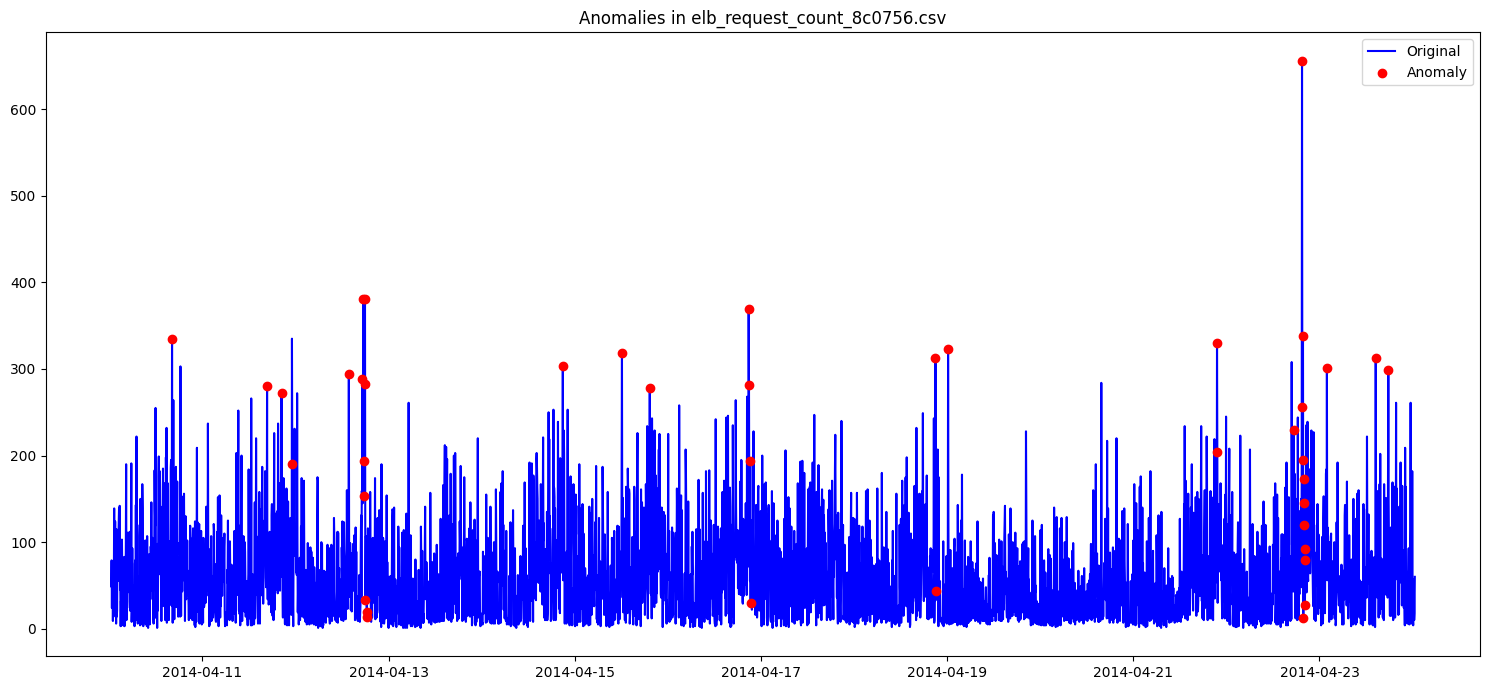



Evaluation for ec2_cpu_utilization_fe7f93.csv:
Total data points: 4026
Anomaly points: 41
Percentage of anomalies: 1.02%


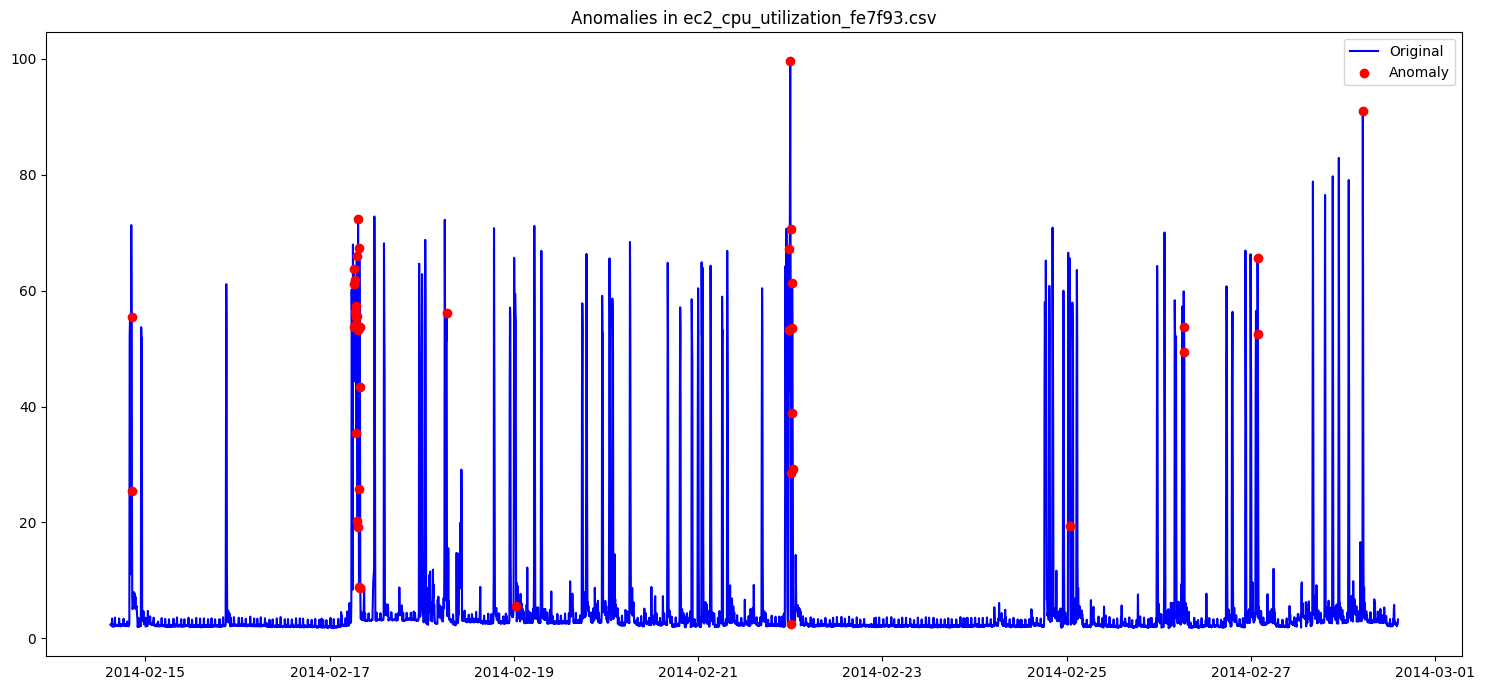



Evaluation for grok_asg_anomaly.csv:
Total data points: 4615
Anomaly points: 47
Percentage of anomalies: 1.02%


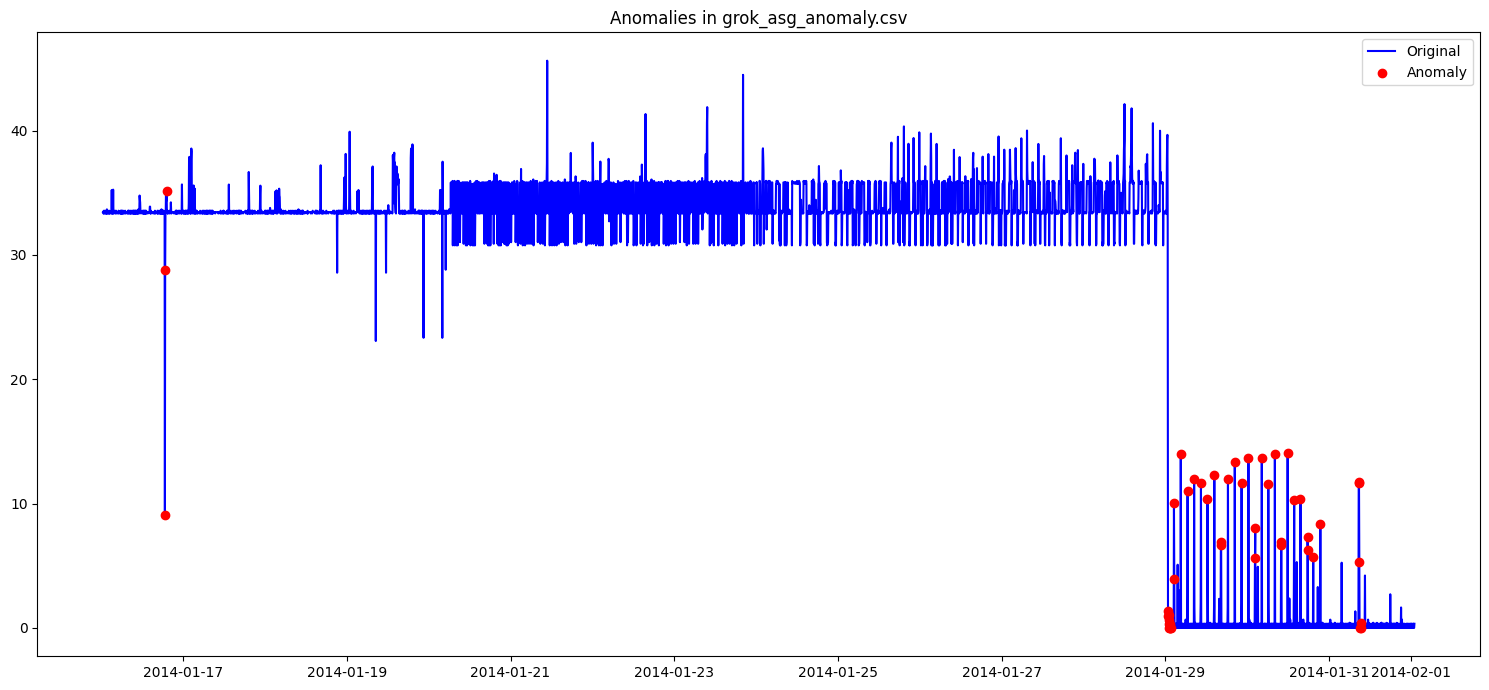



Evaluation for ec2_cpu_utilization_77c1ca.csv:
Total data points: 4026
Anomaly points: 41
Percentage of anomalies: 1.02%


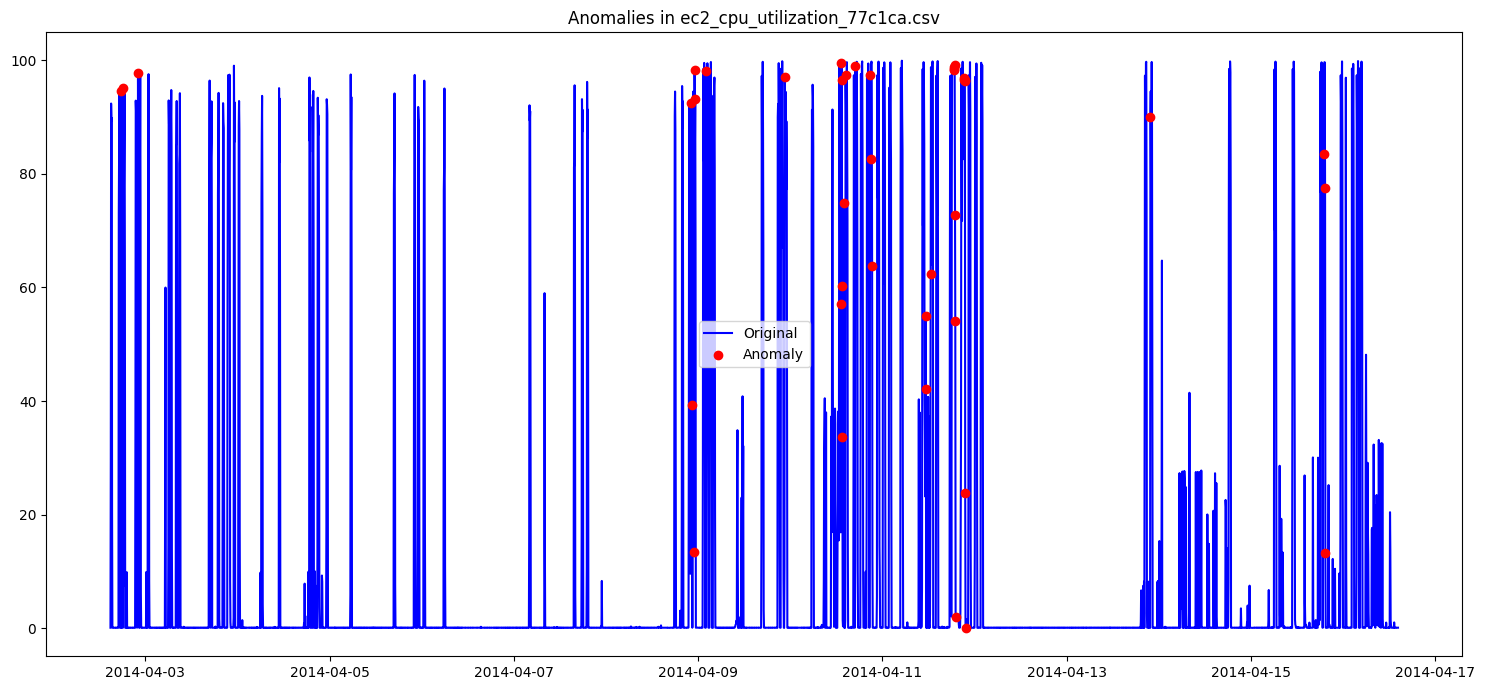



Evaluation for ec2_cpu_utilization_825cc2.csv:
Total data points: 4028
Anomaly points: 41
Percentage of anomalies: 1.02%


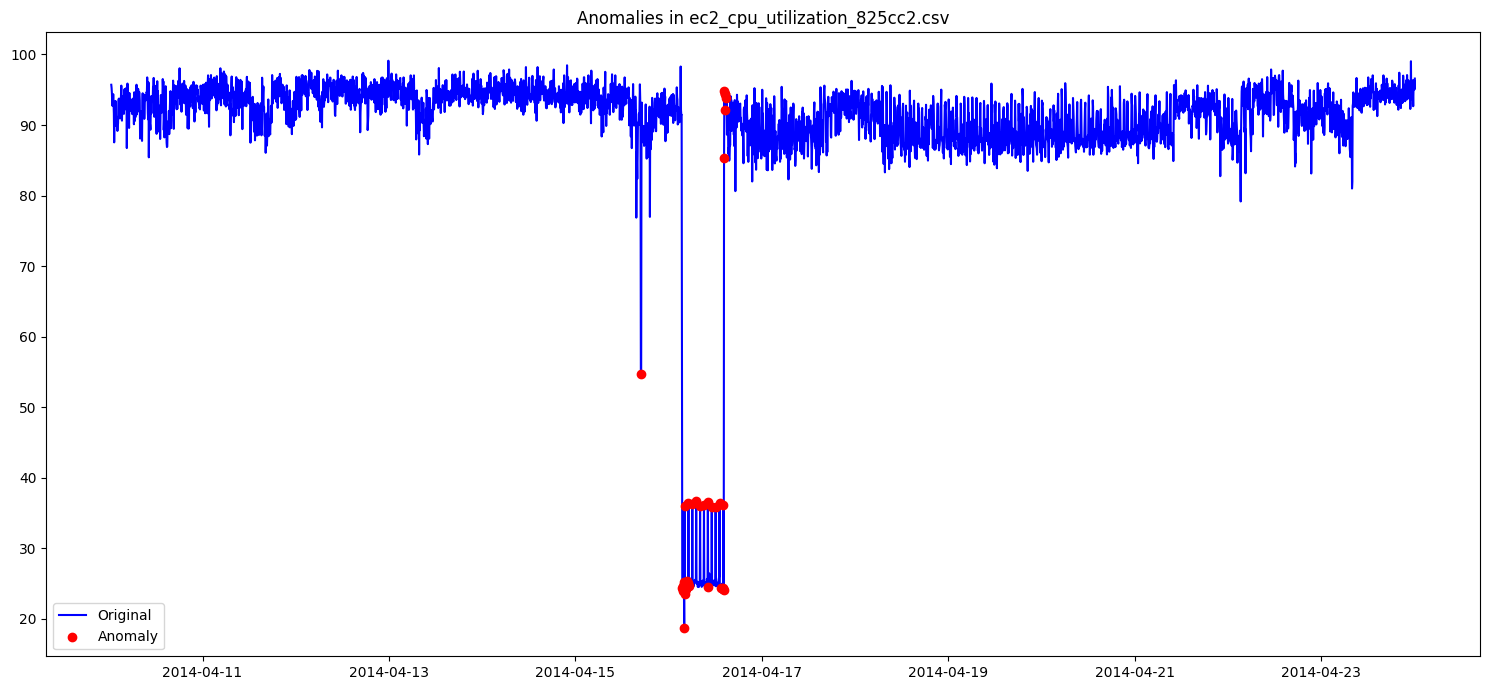



Evaluation for iio_us-east-1_i-a2eb1cd9_NetworkIn.csv:
Total data points: 1237
Anomaly points: 13
Percentage of anomalies: 1.05%


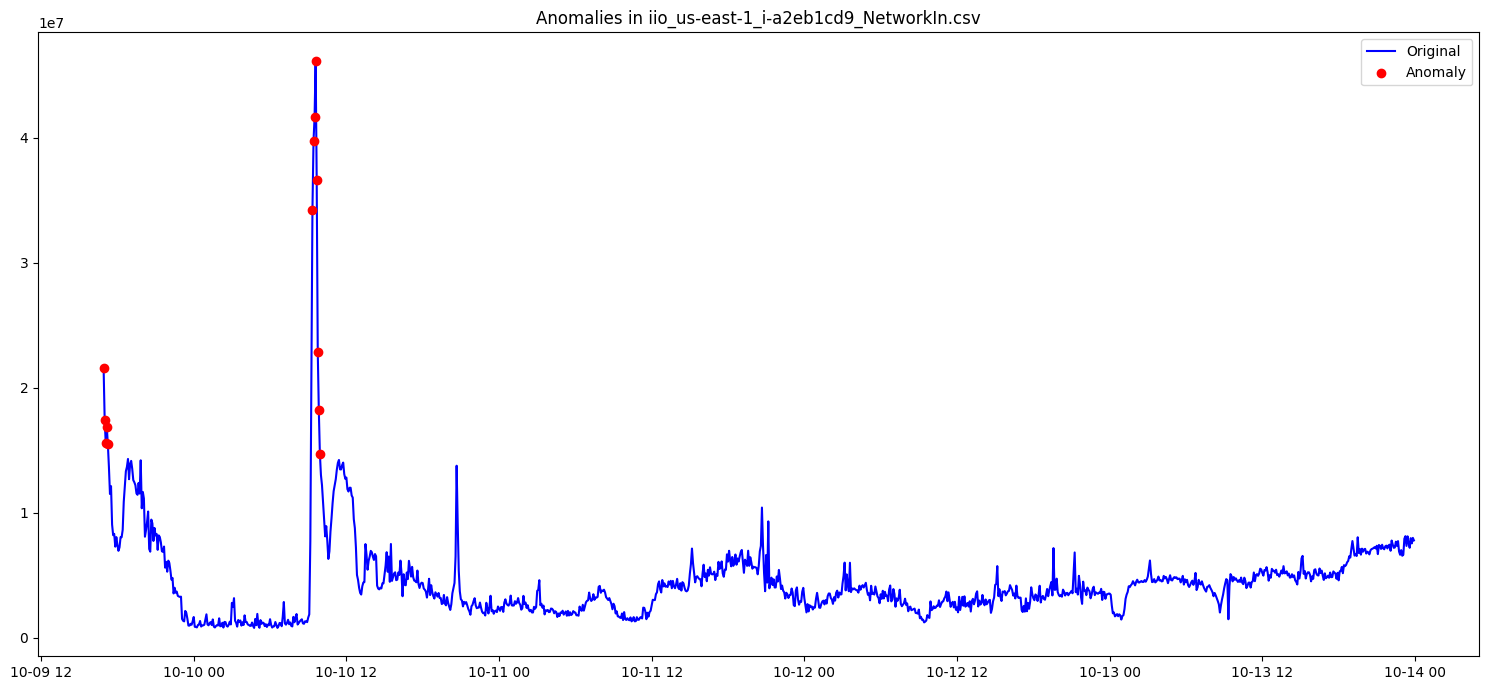



Evaluation for ec2_disk_write_bytes_1ef3de.csv:
Total data points: 4724
Anomaly points: 48
Percentage of anomalies: 1.02%


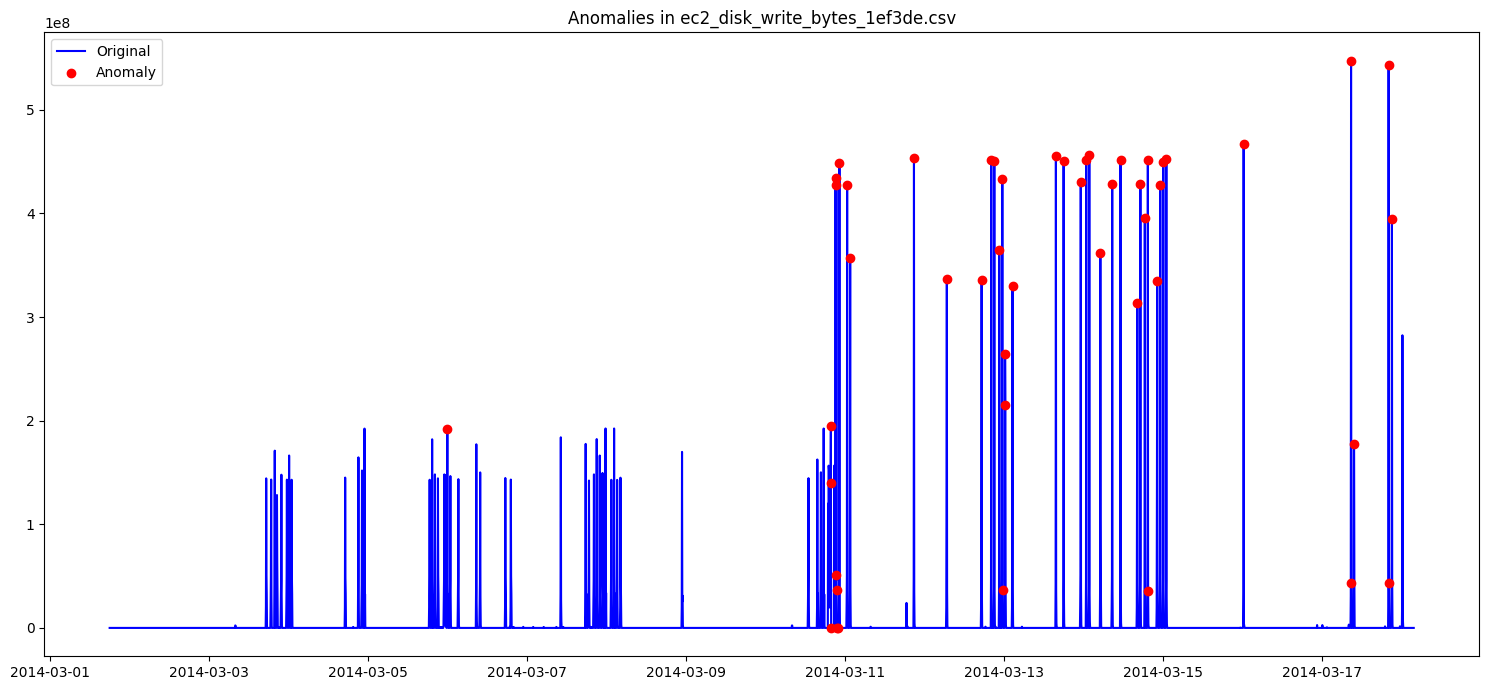



Evaluation for ec2_cpu_utilization_5f5533.csv:
Total data points: 4026
Anomaly points: 41
Percentage of anomalies: 1.02%


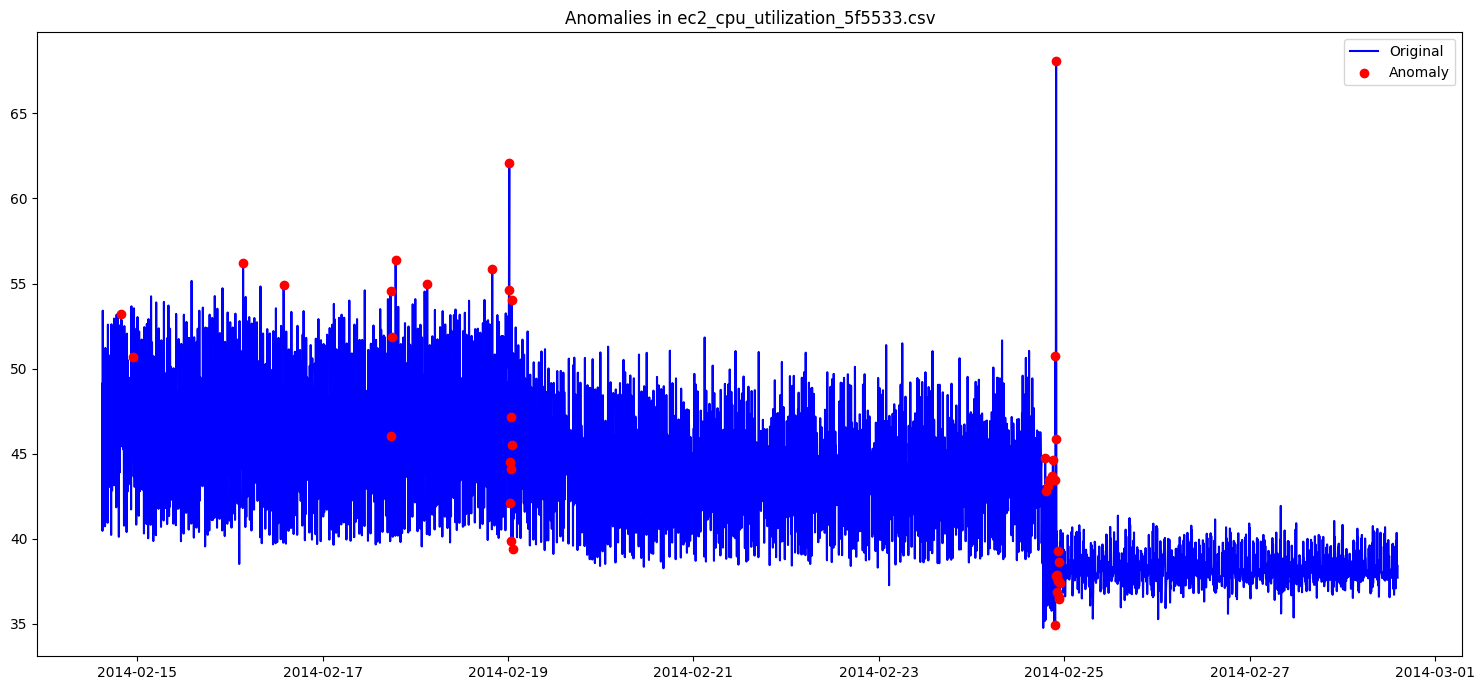



Evaluation for ec2_disk_write_bytes_c0d644.csv:
Total data points: 4026
Anomaly points: 41
Percentage of anomalies: 1.02%


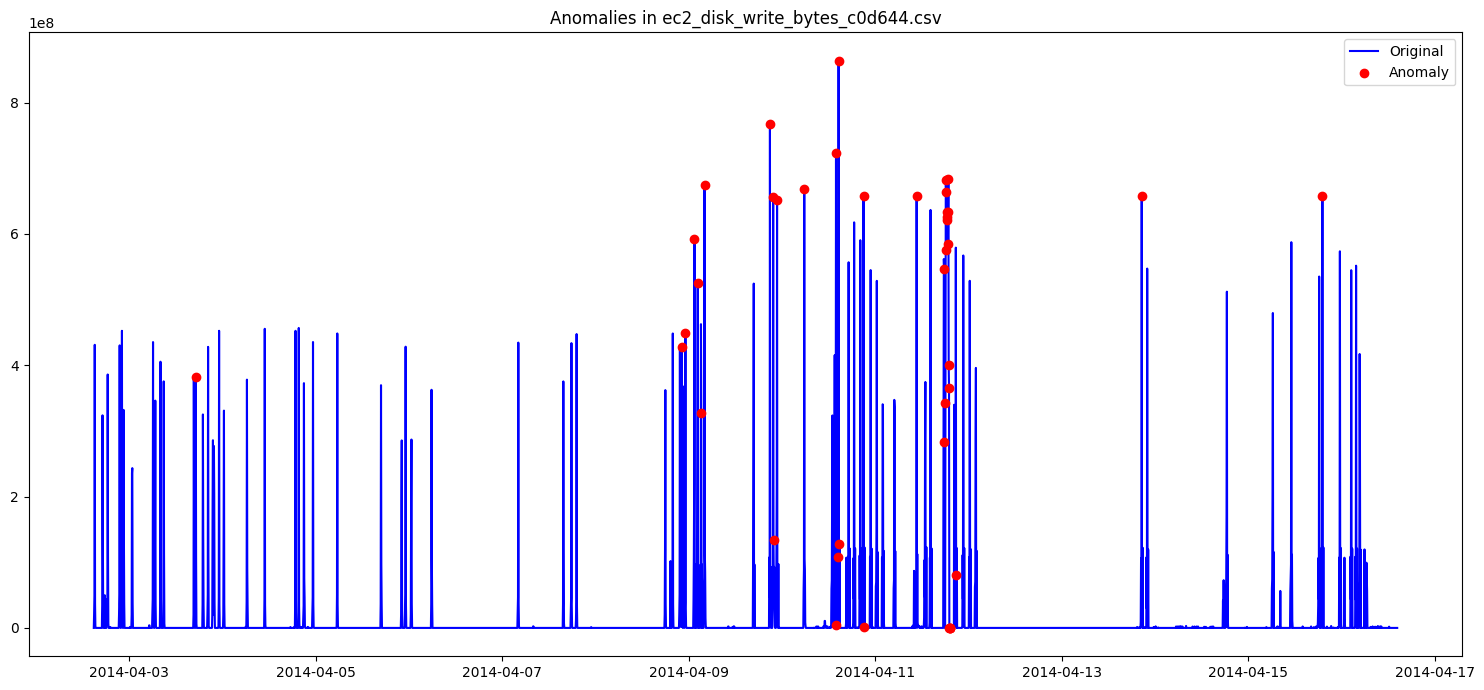



Evaluation for rds_cpu_utilization_cc0c53.csv:
Total data points: 4027
Anomaly points: 41
Percentage of anomalies: 1.02%


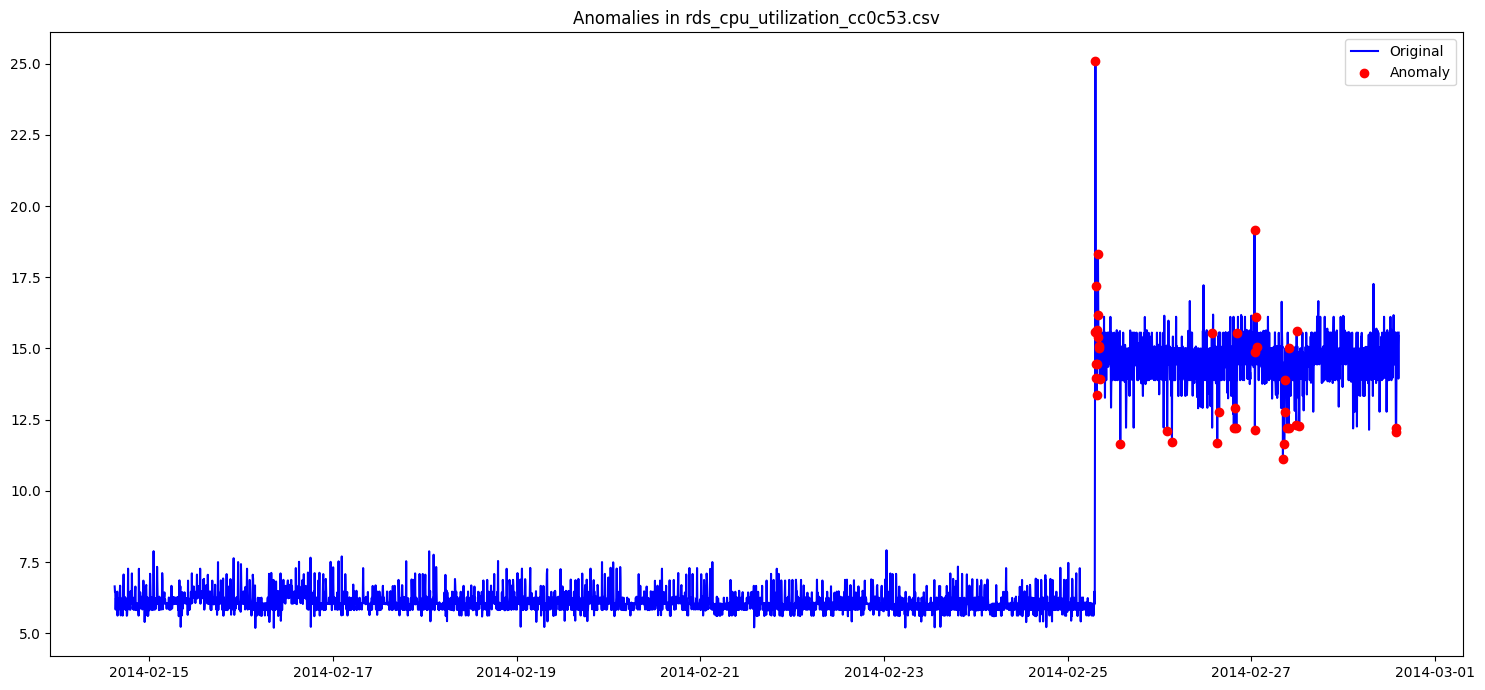



Evaluation for ec2_cpu_utilization_c6585a.csv:
Total data points: 4026
Anomaly points: 41
Percentage of anomalies: 1.02%


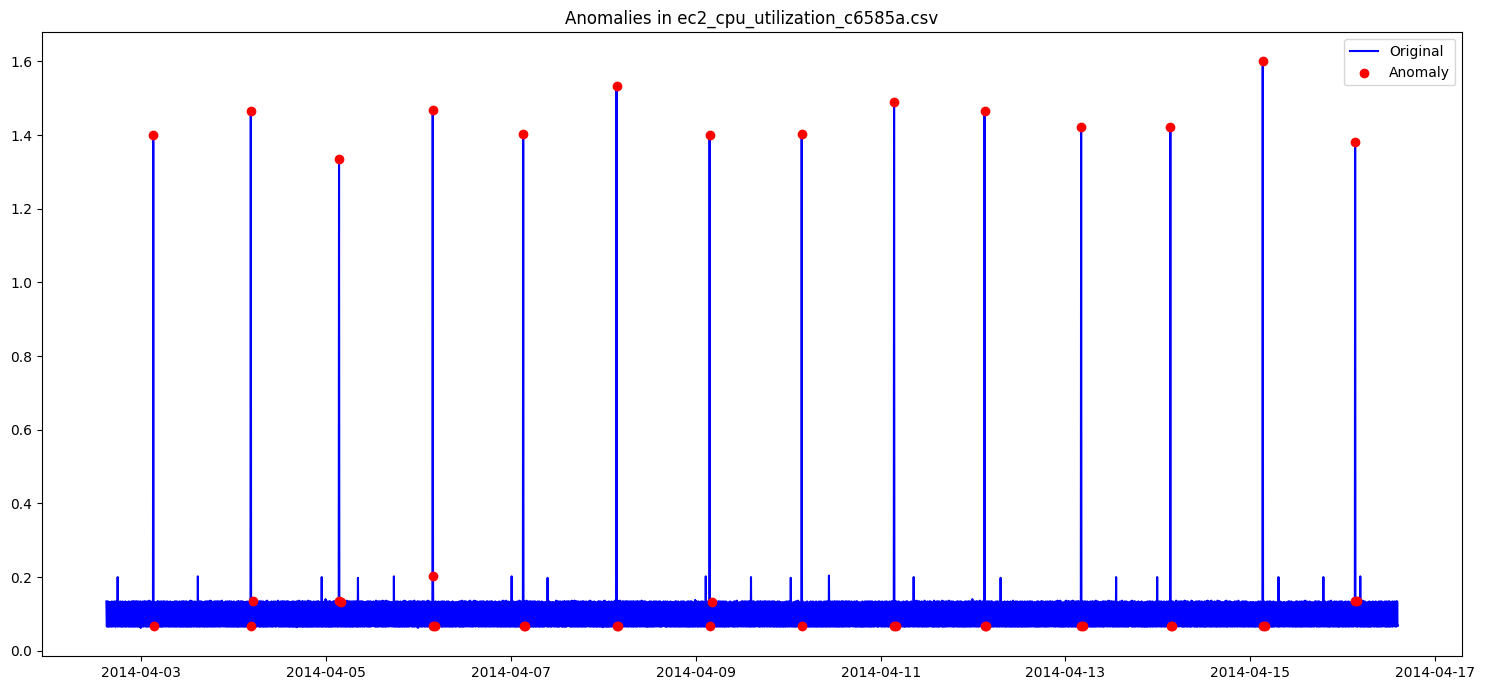



Evaluation for ec2_network_in_257a54.csv:
Total data points: 4028
Anomaly points: 41
Percentage of anomalies: 1.02%


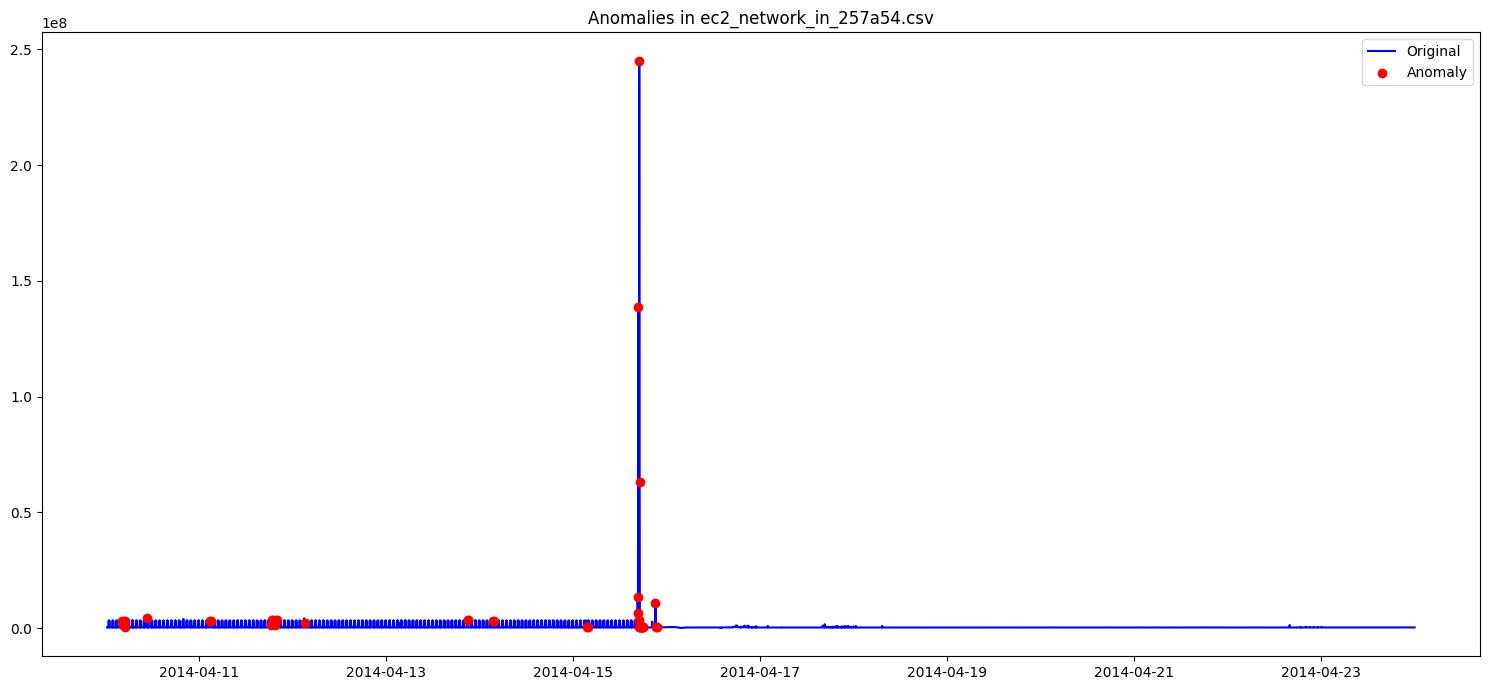



Evaluation for ec2_network_in_5abac7.csv:
Total data points: 4724
Anomaly points: 47
Percentage of anomalies: 0.99%


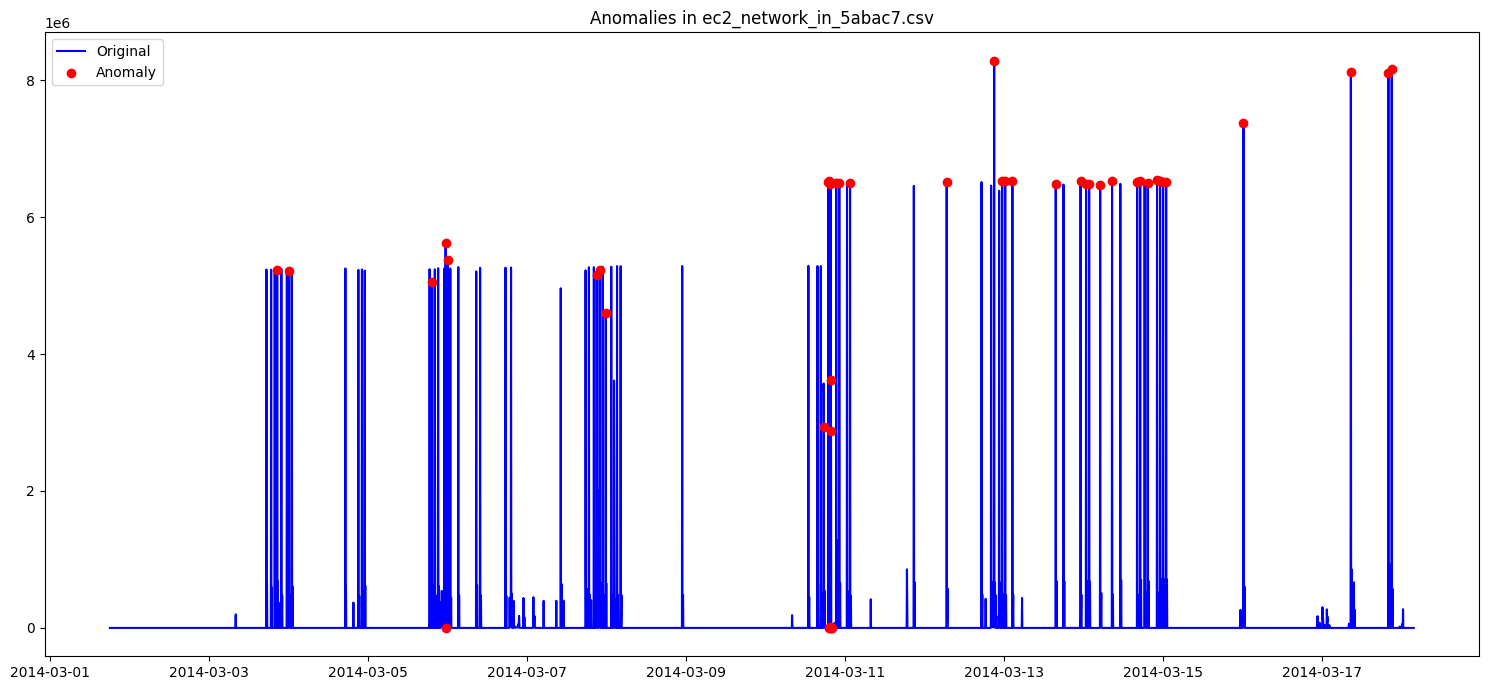



Evaluation for ec2_cpu_utilization_ac20cd.csv:
Total data points: 4031
Anomaly points: 41
Percentage of anomalies: 1.02%


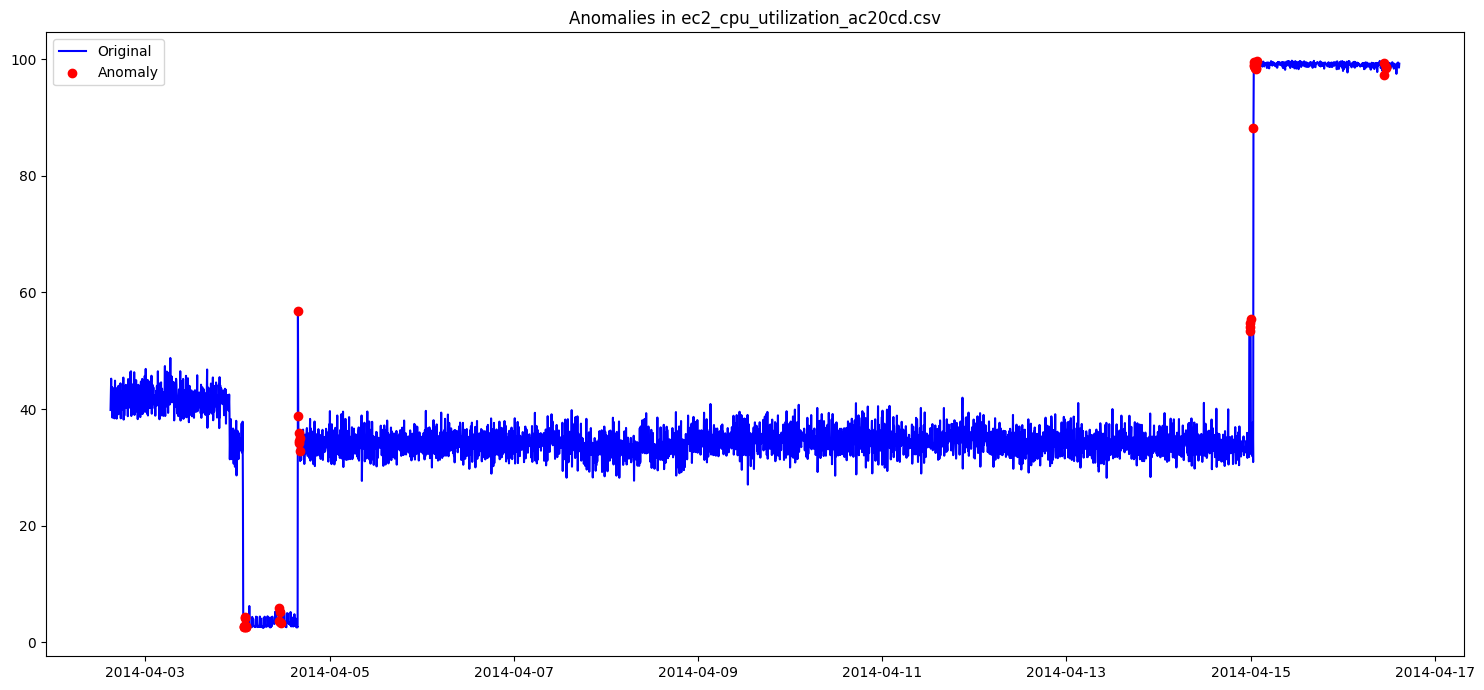



Evaluation for ec2_cpu_utilization_53ea38.csv:
Total data points: 4026
Anomaly points: 41
Percentage of anomalies: 1.02%


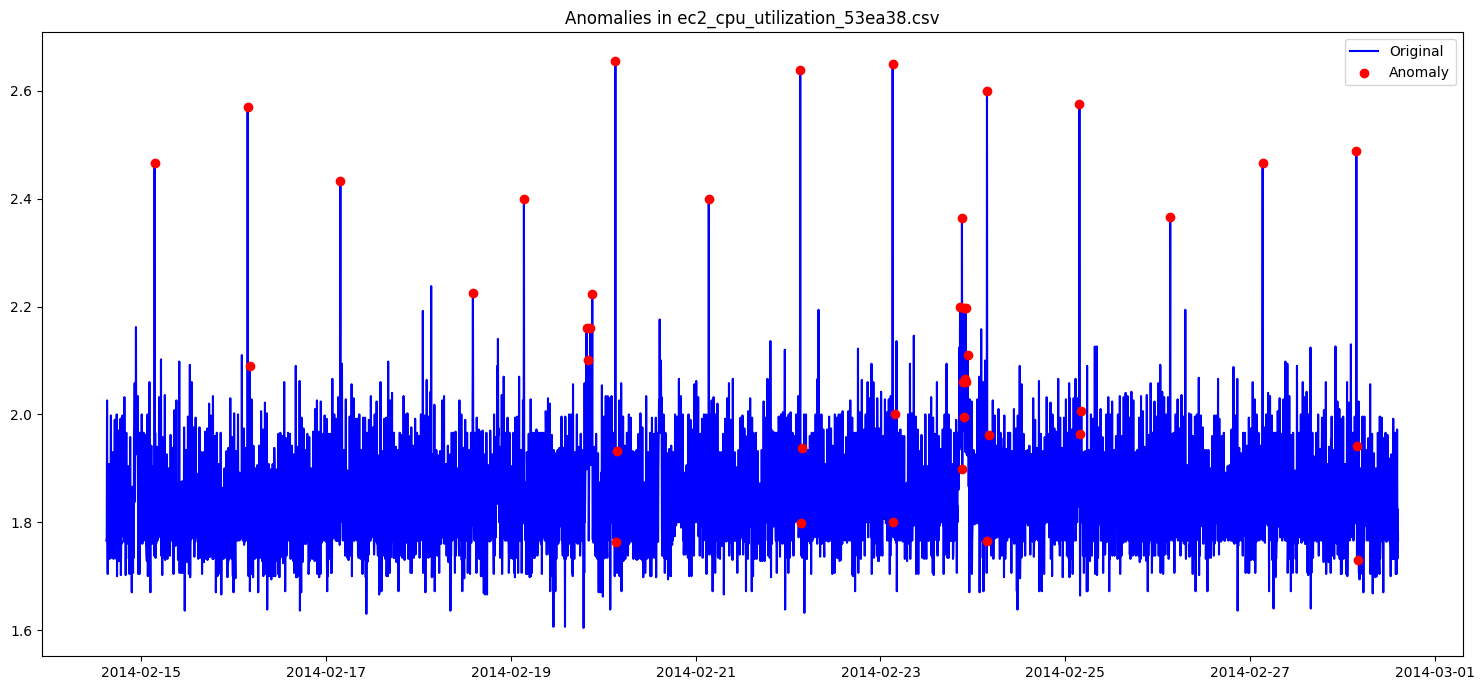



Evaluation for ec2_cpu_utilization_24ae8d.csv:
Total data points: 4026
Anomaly points: 41
Percentage of anomalies: 1.02%


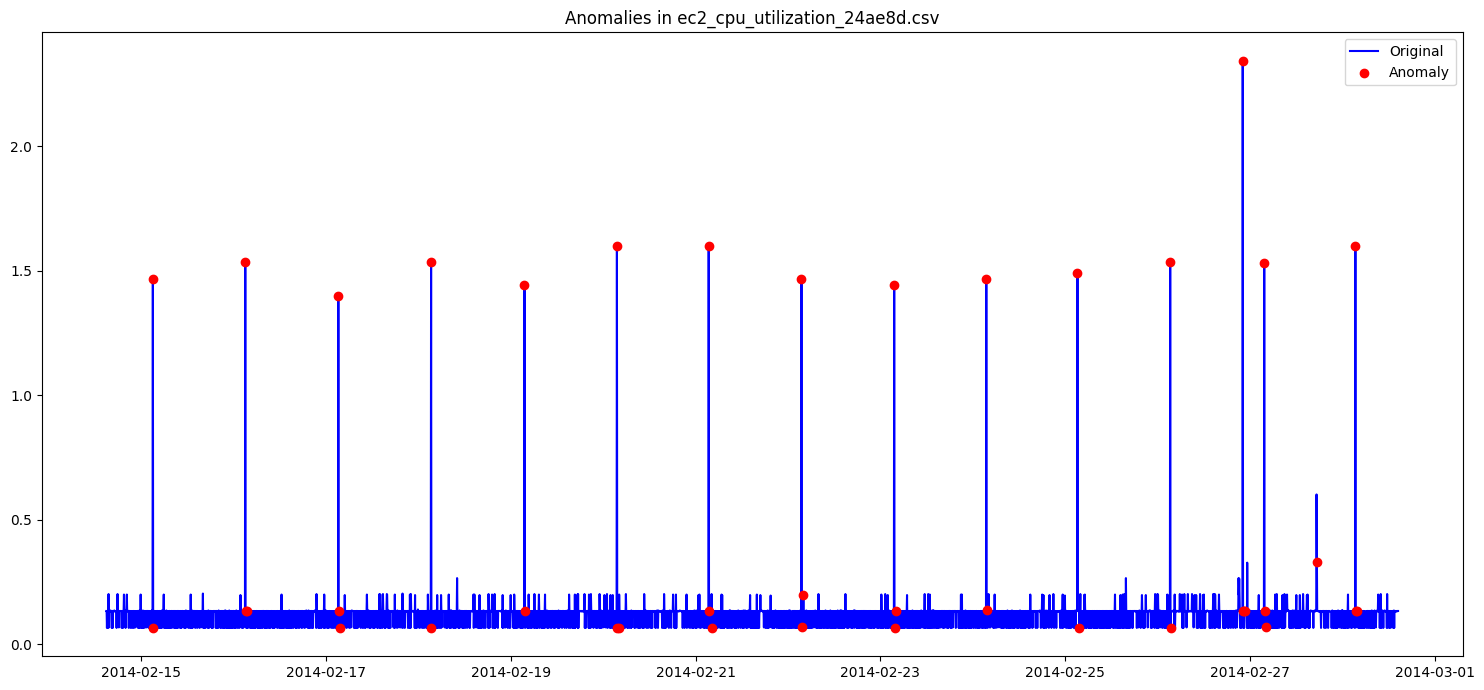



Evaluation for rds_cpu_utilization_e47b3b.csv:
Total data points: 4026
Anomaly points: 41
Percentage of anomalies: 1.02%


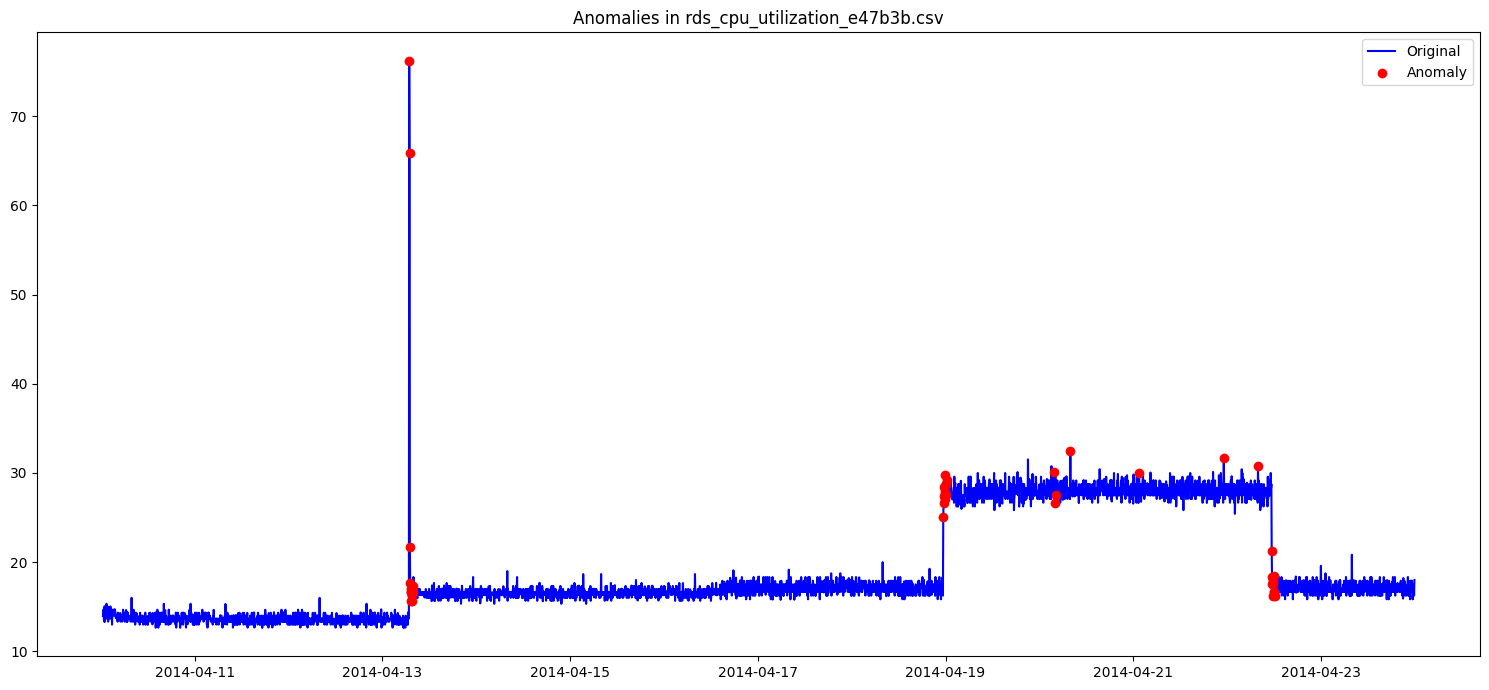

In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Header 1: Function to Evaluate Anomalies
# This function calculates and prints the total number of data points, the number of detected anomalies, 
# and the percentage of data points that are classified as anomalies.
def evaluate_anomalies(df):
    """
    Evaluate the anomalies in the dataset.
    
    Args:
    df (DataFrame): The dataframe containing a column 'anomaly' where -1 represents an anomaly.
    
    Prints:
    - Total number of data points in the dataset.
    - Number of anomaly points.
    - Percentage of data points that are classified as anomalies.
    """
    # Total number of data points in the dataframe
    total_points = len(df)
    
    # Number of data points marked as anomalies (-1 indicates an anomaly)
    anomaly_points = len(df[df['anomaly'] == -1])
    
    # Calculate the percentage of anomalies
    anomaly_percentage = (anomaly_points / total_points) * 100
    
    # Print the evaluation results
    print(f"Total data points: {total_points}")
    print(f"Anomaly points: {anomaly_points}")
    print(f"Percentage of anomalies: {anomaly_percentage:.2f}%")
    

# Header 2: Function to Visualize Anomalies
# This function plots the time series data with anomalies highlighted in red.
def visualize_anomalies(df, title):
    """
    Visualize the time series data with anomalies marked in red.
    
    Args:
    df (DataFrame): The dataframe containing a 'value' column and an 'anomaly' column.
    title (str): The title of the plot.
    """
    # Create a figure to plot the time series data and anomalies
    plt.figure(figsize=(15, 7))
    
    # Plot the original data (non-anomalous points)
    plt.plot(df.index, df['value'], label='Original', color='blue')
    
    # Highlight the anomaly points in red
    plt.scatter(df[df['anomaly'] == -1].index, df[df['anomaly'] == -1]['value'], 
                color='red', label='Anomaly', zorder=5)
    
    # Add title and legend to the plot
    plt.title(title)
    plt.legend()
    
    # Ensure layout is adjusted properly
    plt.tight_layout()

    #display plots
    plt.show()


# Header 3: Evaluate and Visualize Anomalies for All Datasets
# This section iterates over multiple datasets, evaluates the anomalies, and visualizes the results.
for file, df in datasets.items():
    print(f"Evaluation for {file}:")
    
    # Evaluate the anomalies in the current dataset
    evaluate_anomalies(df)
    
    # Visualize the anomalies for the current dataset
    visualize_anomalies(df, f"Anomalies in {file}")
    
    # Print a separator between datasets for clarity
    print("\n" + "="*50 + "\n")


# Function to Tune Anomaly Detection

This function performs anomaly detection using different contamination levels and returns a dictionary with contamination levels as keys and the count of detected anomalies as values.

## Applying tuning to sample dataset

This section applies the tuning process to a sample dataset and visualizes the results.

Starting anomaly detection...
Selected features for anomaly detection: ['value', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_6', 'diff_from_mean']
Standardized the features.
Isolation Forest trained with contamination level: 0.005
Anomaly detection complete. Anomalies marked in the 'anomaly' column.
Starting anomaly detection...
Selected features for anomaly detection: ['value', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_6', 'diff_from_mean']
Standardized the features.
Isolation Forest trained with contamination level: 0.01
Anomaly detection complete. Anomalies marked in the 'anomaly' column.
Starting anomaly detection...
Selected features for anomaly detection: ['value', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_6', 'diff_from_mean']
Standardized the features.
Isolation Forest trained with contamination level: 0.02
Anomaly detection complete. Anomalies marked in the 'anomaly' column.
Starting anomaly detection...
Selected features for anomaly detection: ['value', 'rolling_mean',

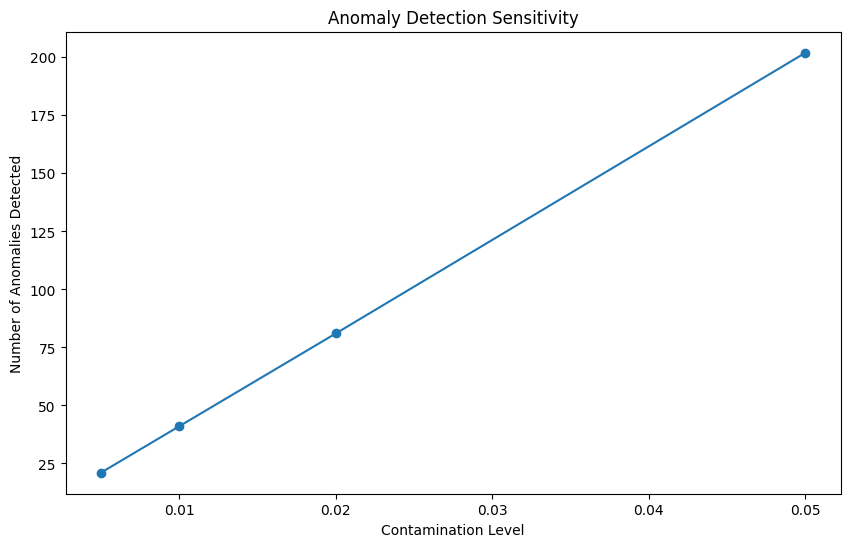

In [6]:
# Import necessary libraries
import matplotlib.pyplot as plt

def tune_anomaly_detection(df, contamination_range=[0.005, 0.01, 0.02, 0.05]):
    """
    Tune the contamination level for anomaly detection.

    Args:
    df (DataFrame): The input dataframe on which to perform anomaly detection.
    contamination_range (list): List of contamination values to test.

    Returns:
    dict: A dictionary where keys are contamination values and values are the number of detected anomalies.
    """
    results = {}
    
    # Iterate over the specified contamination levels
    for contamination in contamination_range:
        # Perform anomaly detection with the current contamination value
        df_anomalies = detect_anomalies(df, contamination=contamination)
        
        # Count the number of anomalies (assuming -1 indicates an anomaly)
        anomaly_count = len(df_anomalies[df_anomalies['anomaly'] == -1])
        
        # Store the results (contamination level and anomaly count)
        results[contamination] = anomaly_count
    
    return results

# Select a sample file from the available datasets
sample_file = list(datasets.keys())[0]

# Run the anomaly detection tuning process on the selected dataset
tuning_results = tune_anomaly_detection(datasets[sample_file])

# Print tuning results for each contamination level
print("Tuning results:")
for contamination, anomaly_count in tuning_results.items():
    print(f"Contamination: {contamination:.3f}, Anomalies detected: {anomaly_count}")


# Header 3: Visualize Tuning Results
# This section plots the contamination levels against the number of anomalies detected.

# Create a plot to visualize the sensitivity of the anomaly detection
plt.figure(figsize=(10, 6))
plt.plot(list(tuning_results.keys()), list(tuning_results.values()), marker='o')

# Add labels and title to the plot
plt.xlabel('Contamination Level')
plt.ylabel('Number of Anomalies Detected')
plt.title('Anomaly Detection Sensitivity')

# Display the plot
plt.show()


# Function to Investigate Anomalies in the Dataset

This function performs a deeper investigation into the detected anomalies by showing statistics, top anomalies, and temporal distribution based on the hour.

## Investigate Anomalies in a Sample Dataset

This section applies the investigation function to a sample dataset.

### Visualize the Distribution of Anomaly Values

This section creates a histogram showing the distribution of the anomaly values.


Anomaly Statistics:
count    202.000000
mean     168.341584
std      103.012713
min        2.000000
25%       79.250000
50%      180.000000
75%      241.250000
max      656.000000
Name: value, dtype: float64

Top 5 highest anomaly values:
                     value  rolling_mean  rolling_std  lag_1  lag_6  hour  \
timestamp                                                                   
2014-04-22 19:30:00  656.0    132.583333   172.474746  175.0  136.0    19   
2014-04-12 17:30:00  381.0    134.083333   112.130977  162.0   37.0    17   
2014-04-12 17:55:00  381.0    210.500000   102.647234  283.0  162.0    17   
2014-04-16 20:50:00  369.0    144.916667   103.643145  262.0   39.0    20   
2014-04-22 19:45:00  338.0    190.000000   170.126691  195.0  150.0    19   

                     day_of_week  diff_from_mean  anomaly  
timestamp                                                  
2014-04-22 19:30:00            1      523.416667       -1  
2014-04-12 17:30:00            5      246

/tmp/ipykernel_48973/1190748291.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['hour'] = anomalies.index.hour


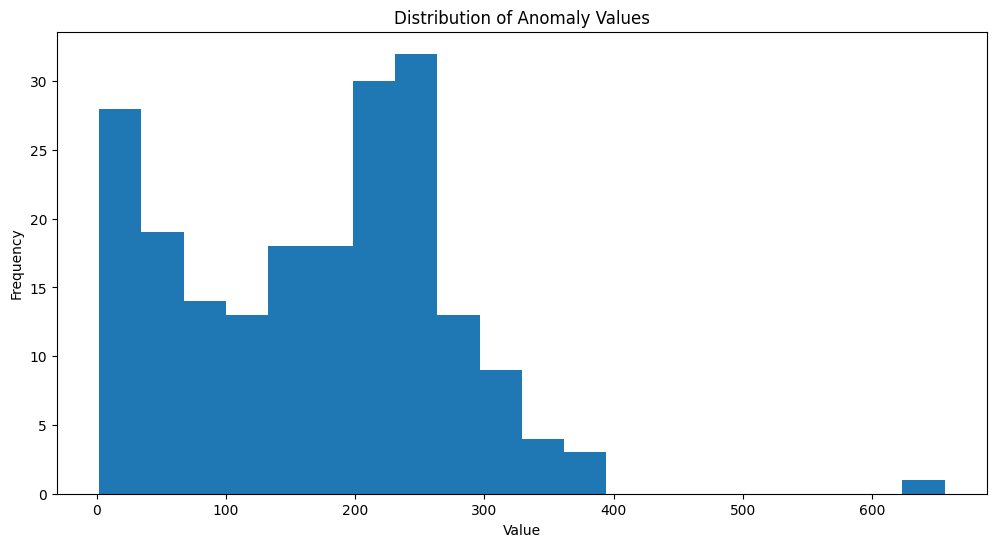

In [7]:
# Importing necessary libraries
import matplotlib.pyplot as plt

# Header 1: Function to Investigate Anomalies in the Dataset
# This function performs a deeper investigation into the detected anomalies by showing statistics,
# top anomalies, and temporal distribution based on the hour.
def investigate_anomalies(df):
    """
    Investigate the anomalies in the dataset by providing key statistics, 
    highest and lowest anomaly values, and temporal distribution.

    Args:
    df (DataFrame): The dataframe containing a 'value' column and an 'anomaly' column 
    where -1 indicates an anomaly.
    
    Prints:
    - Descriptive statistics of the anomaly values.
    - Top 5 highest and lowest anomaly values.
    - Temporal distribution of anomalies based on the hour of occurrence.
    """
    # Filter out the rows where anomalies are detected (-1 indicates anomaly)
    anomalies = df[df['anomaly'] == -1]
    
    # Anomaly Statistics: Summary statistics of the values marked as anomalies
    print("Anomaly Statistics:")
    print(anomalies['value'].describe())
    
    # Display the top 5 highest anomaly values
    print("\nTop 5 highest anomaly values:")
    print(anomalies.nlargest(5, 'value'))
    
    # Display the top 5 lowest anomaly values
    print("\nTop 5 lowest anomaly values:")
    print(anomalies.nsmallest(5, 'value'))
    
    # Analyze the temporal distribution of anomalies by the hour of the day
    print("\nTemporal distribution of anomalies:")
    
    # Extract the hour from the index (assuming it's a datetime index)
    anomalies['hour'] = anomalies.index.hour
    
    # Show the count of anomalies by hour and sort by hour for better readability
    print(anomalies['hour'].value_counts().sort_index())
    

# Header 2: Investigate Anomalies in a Sample Dataset
# This section applies the investigation function to a sample dataset.
sample_file = list(datasets.keys())[0]

# Investigate anomalies in the selected sample dataset
investigate_anomalies(datasets[sample_file])


# Header 3: Visualize the Distribution of Anomaly Values
# This section creates a histogram showing the distribution of the anomaly values.

# Create a figure to visualize the distribution of anomaly values
plt.figure(figsize=(12, 6))

# Plot the distribution of the 'value' column where anomalies are detected (-1)
plt.hist(datasets[sample_file].loc[datasets[sample_file]['anomaly'] == -1, 'value'], bins=20)

# Add title and axis labels to the plot
plt.title('Distribution of Anomaly Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


# Helper Function to Create Sequences

This function creates sequences of a specified length from the data to feed into the LSTM model.

## LSTM Autoencoder for Anomaly Detection

This function builds, trains, and applies an LSTM Autoencoder to detect anomalies in the data.

### Isolation Forest for Anomaly Detection

This function applies Isolation Forest to detect anomalies in the data.

#### Apply and Compare Anomaly Detection Methods

This section applies both Isolation Forest and LSTM Autoencoder to a sample dataset, compares the results, and visualizes the anomalies detected by each method.

##### Visualize the Comparison of Anomaly Detection Methods

This section plots the time series data with anomalies detected by Isolation Forest and LSTM Autoencoder.


2024-09-14 18:38:12.598182: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 18:38:12.600043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 18:38:12.633605: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 18:38:12.634474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 18:38:13.285774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

126/126 [==============================] - 1s 4ms/step
Isolation Forest anomalies: 404
LSTM Autoencoder anomalies: 29
Overlapping anomalies: 9


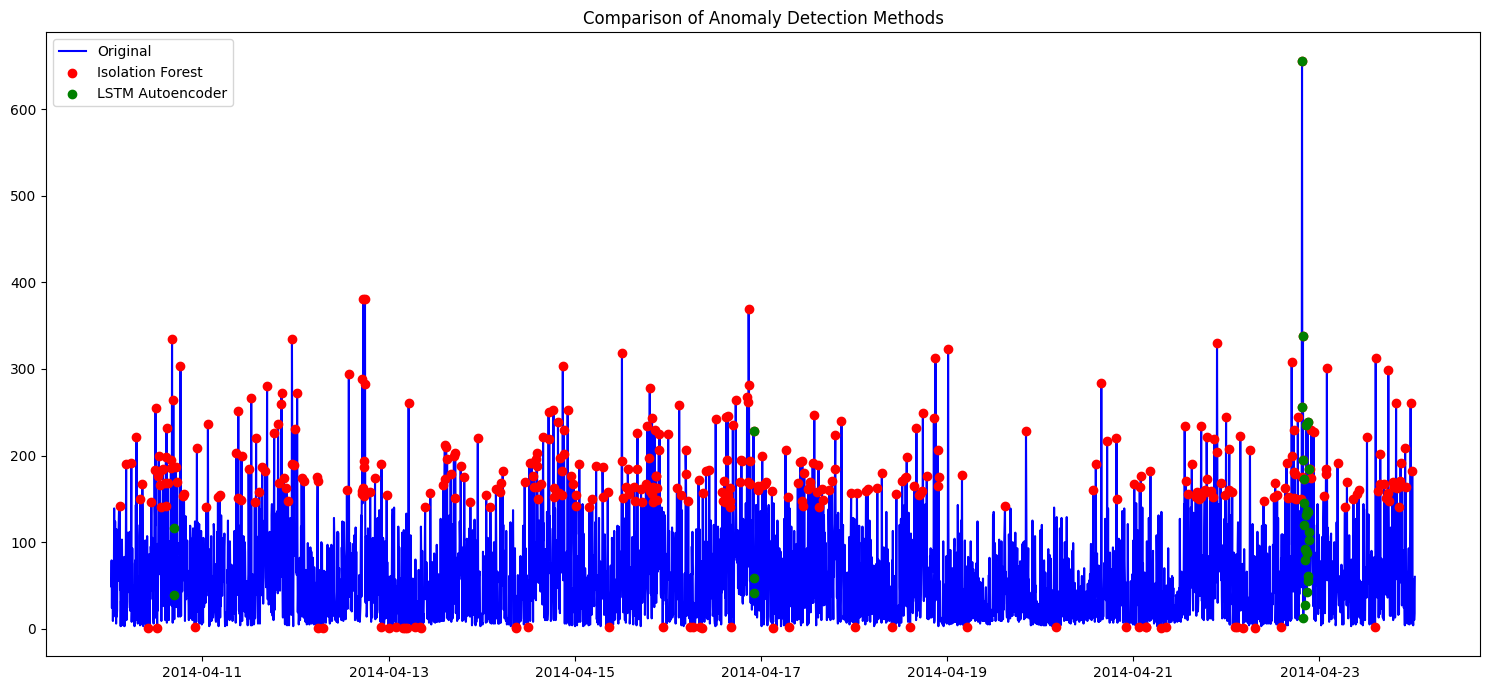

In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Header 1: Helper Function to Create Sequences
# This function creates sequences of a specified length from the data to feed into the LSTM model.
def create_sequences(data, seq_length):
    """
    Create sequences from the input data for LSTM.

    Args:
    data (ndarray): Input data as a NumPy array.
    seq_length (int): Length of each sequence.

    Returns:
    ndarray: 3D array of sequences.
    """
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)


# Header 2: LSTM Autoencoder for Anomaly Detection
# This function builds, trains, and applies an LSTM Autoencoder to detect anomalies in the data.
def lstm_autoencoder(df, seq_length=24, threshold_multiplier=3):
    """
    Train and apply an LSTM autoencoder to detect anomalies in a time series.

    Args:
    df (DataFrame): Input data containing a 'value' column.
    seq_length (int): The length of each input sequence for the LSTM.
    threshold_multiplier (int): Multiplier for setting the anomaly detection threshold.

    Returns:
    DataFrame: The input DataFrame with an additional column 'lstm_anomaly' indicating detected anomalies.
    """
    # Preserve the original DataFrame
    original_df = df.copy()
    
    # Scale the 'value' column to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['value']])
    
    # Prepare sequences for the LSTM model
    sequences = create_sequences(scaled_data, seq_length)
    
    # Define the LSTM autoencoder model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(seq_length, 1)),
        RepeatVector(seq_length),
        LSTM(64, activation='relu', return_sequences=True),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # Train the model (set verbose to 0 for silent training)
    model.fit(sequences, sequences, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    
    # Predict using the trained autoencoder to get the reconstructed sequences
    reconstructions = model.predict(sequences)
    
    # Calculate the Mean Squared Error (MSE) for each sequence
    mse = np.mean(np.power(sequences - reconstructions, 2), axis=(1,2))
    
    # Define the anomaly detection threshold (mean + multiplier * standard deviation)
    threshold = np.mean(mse) + threshold_multiplier * np.std(mse)
    
    # Create a result DataFrame with the same index as the original
    result_df = pd.DataFrame(index=original_df.index)
    result_df['value'] = original_df['value']
    
    # Preserve the 'anomaly' column if it exists
    if 'anomaly' in original_df.columns:
        result_df['anomaly'] = original_df['anomaly']
    
    # Add the 'lstm_anomaly' column, padding with NaN for the first seq_length-1 rows
    result_df['lstm_anomaly'] = pd.Series([np.nan]*(seq_length-1) + list((mse > threshold).astype(int)), 
                                           index=original_df.index)
    
    return result_df


# Header 3: Isolation Forest for Anomaly Detection
# This function applies Isolation Forest to detect anomalies in the data.
def apply_isolation_forest(df):
    """
    Apply Isolation Forest for anomaly detection.

    Args:
    df (DataFrame): Input data containing a 'value' column.

    Returns:
    DataFrame: The input DataFrame with an additional 'anomaly' column (-1 indicates anomaly).
    """
    clf = IsolationForest(contamination=0.1, random_state=42)
    df['anomaly'] = clf.fit_predict(df[['value']])
    return df


# Header 4: Apply and Compare Anomaly Detection Methods
# This section applies both Isolation Forest and LSTM Autoencoder to a sample dataset,
# compares the results, and visualizes the anomalies detected by each method.

# Select a sample dataset
sample_file = list(datasets.keys())[0]

# Apply Isolation Forest to detect anomalies
datasets[sample_file] = apply_isolation_forest(datasets[sample_file])

# Apply LSTM Autoencoder to detect anomalies
datasets[sample_file] = lstm_autoencoder(datasets[sample_file])

# Compare the number of anomalies detected by each method
isolation_forest_anomalies = datasets[sample_file]['anomaly'] == -1
lstm_anomalies = datasets[sample_file]['lstm_anomaly'] == 1

# Print the comparison results
print("Isolation Forest anomalies:", sum(isolation_forest_anomalies))
print("LSTM Autoencoder anomalies:", sum(lstm_anomalies))
print("Overlapping anomalies:", sum(isolation_forest_anomalies & lstm_anomalies))

# Header 5: Visualize the Comparison of Anomaly Detection Methods
# This section plots the time series data with anomalies detected by Isolation Forest and LSTM Autoencoder.

plt.figure(figsize=(15, 7))

# Plot the original time series data
plt.plot(datasets[sample_file].index, datasets[sample_file]['value'], label='Original', color='blue')

# Highlight anomalies detected by Isolation Forest in red
plt.scatter(datasets[sample_file][isolation_forest_anomalies].index, 
            datasets[sample_file][isolation_forest_anomalies]['value'], 
            color='red', label='Isolation Forest', zorder=5)

# Highlight anomalies detected by LSTM Autoencoder in green
plt.scatter(datasets[sample_file][lstm_anomalies].index, 
            datasets[sample_file][lstm_anomalies]['value'], 
            color='green', label='LSTM Autoencoder', zorder=5)

# Add title, legend, and display the plot
plt.title('Comparison of Anomaly Detection Methods')
plt.legend()
plt.tight_layout()
plt.show()


# Function to Score Anomalies

This function calculates various anomaly scores, categorizes the anomalies, and returns the updated DataFrame.

## Apply Scoring to All Datasets

Loop through each dataset, apply the scoring function, and update the dataset.

### Analyze and Visualize Anomaly Scoring for a Sample Dataset

Select a sample dataset to analyze the results of the scoring process.

#### Visualize Anomaly Scores Over Time

This section visualizes the anomaly scores across the time series data using a scatter plot.

##### This section also presents the report containing structured summary of insights, highlighting the most critical anomalies, their categories, and suggested actions based on their severity scores.

Anomaly categories:
category
Temporary Spikes    259
Gradual Drifts      132
Sudden Drops         13
Name: count, dtype: int64

Top 5 highest scoring anomalies:
                     value  anomaly  lstm_anomaly    z_score  deviation_score  \
timestamp                                                                       
2014-04-22 19:30:00  656.0       -1           1.0  10.493211        10.493211   
2014-04-12 17:30:00  381.0       -1           0.0   5.636952         5.636952   
2014-04-12 17:55:00  381.0       -1           0.0   5.636952         5.636952   
2014-04-22 19:45:00  338.0       -1           1.0   4.877609         4.877609   
2014-04-12 17:50:00  283.0       -1           0.0   3.906357         3.906357   

                     anomaly_group  duration_score  anomaly_score  \
timestamp                                                           
2014-04-22 19:30:00            586             5.0      18.801311   
2014-04-12 17:30:00            122             7.0      11.72171

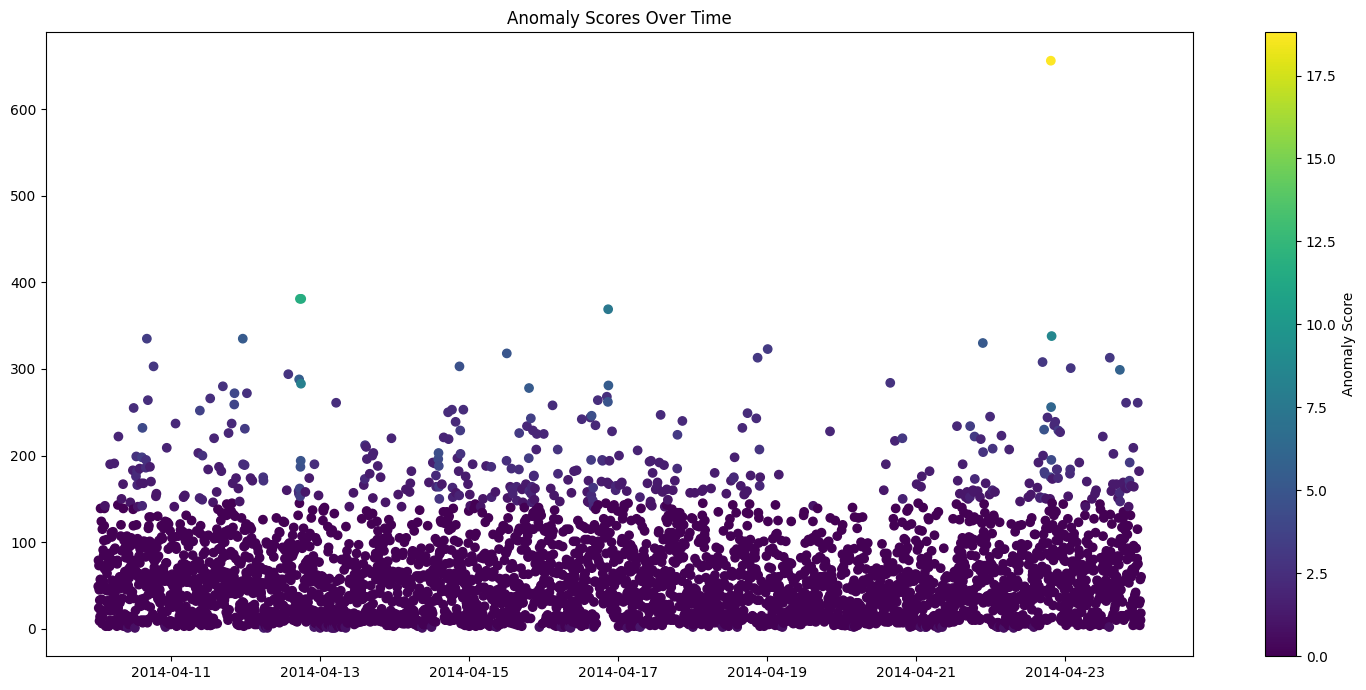

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Header 1: Function to Score Anomalies
# This function calculates various anomaly scores, categorizes the anomalies, and returns the updated DataFrame.
def score_anomalies(df):
    """
    Score anomalies based on deviation from the mean (z-score) and the duration of consecutive anomalies.

    Args:
    df (DataFrame): The input DataFrame containing 'value' and 'anomaly' columns.
    
    Returns:
    DataFrame: The DataFrame with additional columns for z-score, deviation score, duration score, 
               and combined anomaly score. It also categorizes anomalies into 'Temporary Spikes', 'Gradual Drifts', and 'Sudden Drops'.
    """
    # Calculate z-score (standardized value) for each data point
    df['z_score'] = (df['value'] - df['value'].mean()) / df['value'].std()
    
    # Calculate deviation score (absolute z-score)
    df['deviation_score'] = np.abs(df['z_score'])
    
    # Calculate duration score for consecutive anomalies
    # 'anomaly_group' assigns a unique group number to consecutive anomalies
    df['anomaly_group'] = (df['anomaly'] != df['anomaly'].shift()).cumsum()
    
    # Count the number of consecutive anomalies in each group
    anomaly_durations = df[df['anomaly'] == -1].groupby('anomaly_group').size()
    
    # Map the anomaly duration to the original DataFrame
    df['duration_score'] = df['anomaly_group'].map(anomaly_durations).fillna(0)
    
    # Combine the deviation and duration scores to calculate the final anomaly score
    df['anomaly_score'] = df['deviation_score'] * np.log1p(df['duration_score'])  # log1p for smooth scaling
    
    # Categorize anomalies into 'emporary Spikes', 'Gradual Drifts', and 'Sudden Drops' based on their scores
    df.loc[df['anomaly'] == -1, 'category'] = pd.cut(
        df.loc[df['anomaly'] == -1, 'anomaly_score'],
        bins=[0, 2, 5, np.inf],  # Score thresholds: 0-2 (Low), 2-5 (Medium), 5+ (High)
        labels=['Temporary Spikes', 'Gradual Drifts', 'Sudden Drops']
    )
    
    return df


# Header 2: Apply Scoring to All Datasets
# Loop through each dataset, apply the scoring function, and update the dataset.
for file, df in datasets.items():
    datasets[file] = score_anomalies(df)


# Header 3: Analyze and Visualize Anomaly Scoring for a Sample Dataset
# Select a sample dataset to analyze the results of the scoring process.
sample_file = list(datasets.keys())[0]
sample_df = datasets[sample_file]

# Print the counts of each anomaly category (Low, Medium, High)
print("Anomaly categories:")
print(sample_df['category'].value_counts())

# Print the top 5 anomalies with the highest scores
print("\nTop 5 highest scoring anomalies:")
print(sample_df[sample_df['anomaly'] == -1].nlargest(5, 'anomaly_score'))


# Header 4: Visualize Anomaly Scores Over Time
# This section visualizes the anomaly scores across the time series data using a scatter plot.

# Create a scatter plot of the values, color-coded by anomaly score
plt.figure(figsize=(15, 7))

# The scatter plot colors each point based on the anomaly score
plt.scatter(sample_df.index, sample_df['value'], c=sample_df['anomaly_score'], cmap='viridis')

# Add a color bar to represent the anomaly score magnitude
plt.colorbar(label='Anomaly Score')

# Set title and show the plot
plt.title('Anomaly Scores Over Time')
plt.tight_layout()
plt.show()


# Evaluate the model

The model would be evaluated using the evaluation metrics.

### 1) Precision:
The proportion of correctly identified anomalies out of all anomalies
identified by the model. Higher precision indicates fewer false positives.

### 2) Recall:
The proportion of actual anomalies correctly identified by the model.
Higher recall indicates fewer false negatives.

### 3) F1 Score:
The harmonic mean of precision and recall, providing a balance
between the two metrics.


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_anomaly_detection(true_labels, predicted_labels):
    """
    Evaluates the precision, recall, and F1 score of anomaly detection models.

    Args:
    true_labels (ndarray or Series): Ground truth binary labels (0: normal, 1: anomaly).
    predicted_labels (ndarray or Series): Predicted binary labels (0: normal, 1: anomaly).

    Prints:
    - Precision, Recall, and F1-score.
    """
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")



true_labels = (sample_df['anomaly'] == -1).astype(int)  # Use the Isolation Forest anomalies as ground truth

# Predicted labels from the Isolation Forest
isolation_forest_preds = (sample_df['anomaly'] == -1).astype(int)

# Predicted labels from the LSTM Autoencoder (convert NaNs to 0)
lstm_preds = sample_df['lstm_anomaly'].fillna(0).astype(int)

# Evaluate Isolation Forest
print("Isolation Forest Model Evaluation:")
evaluate_anomaly_detection(true_labels, isolation_forest_preds)

# Evaluate LSTM Autoencoder
print("\nLSTM Autoencoder Model Evaluation:")
evaluate_anomaly_detection(true_labels, lstm_preds)


Isolation Forest Model Evaluation:
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

LSTM Autoencoder Model Evaluation:
Precision: 0.31
Recall: 0.02
F1 Score: 0.04


# Conclusion
The Isolation Forest is performing significantly better than the LSTM Autoencoder on this particular dataset for anomaly detection. The LSTM might need further tuning, more training epochs, or different architecture adjustments.

In [18]:
# Saving the CSV file containing the detected anomalies, their categories, and severity scores.
sample_df.to_csv('detected_anomalies.csv', index=True)